In [10]:
import numpy as np
import pandas as pd
from sklearn import __version__ as sklearn_version

In [3]:
data = pd.read_csv("./data/rec_ab_test.csv")
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


In [4]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)', data=data).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


In [5]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

In [12]:
# Convert treatment to binary
data['recommender_binary'] = (data['recommender'] == 'challenger').astype(int)

# Now create the causal model with the binary treatment
model = CausalModel(
    data=data,
    treatment='recommender_binary',  # Using our new binary variable
    outcome='watch_time',
    graph="digraph {recommender_binary -> watch_time}")

# Identify the causal effect
identified_estimand = model.identify_effect()

# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

/Users/vaclavpechtor/Code/code_examples/causal-inference-in-python-code/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [13]:
# Verify randomization and perform robustness checks
refute_results = model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="random_common_cause"
)

/Users/vaclavpechtor/Code/code_examples/causal-inference-in-python-code/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/vaclavpechtor/Code/code_examples/causal-inference-in-python-code/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/vaclavpechtor/Code/code_examples/causal-inference-in-python-code/env/lib/python3.11/site-packages/dowhy/causal_estimators/r

In [14]:
# Print the estimate details
print(estimate)

# For more detailed results
print("\nCausal Estimate:")
print("Estimated effect:", estimate.value)
print("95% CI:", estimate.get_confidence_intervals())
print("\nEffect significance:")
print(estimate.test_stat_significance())

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                        
─────────────────────(E[watchₜᵢₘₑ])
d[recommender_binary]              
Estimand assumption 1, Unconfoundedness: If U→{recommender_binary} and U→watch_time then P(watch_time|recommender_binary,,U) = P(watch_time|recommender_binary,)

## Realized estimand
b: watch_time~recommender_binary
Target units: ate

## Estimate
Mean value: 0.1426859605911326


Causal Estimate:
Estimated effect: 0.1426859605911326
95% CI: [[-0.04431842  0.32969034]]

Effect significance:
{'p_value': array([0.1343051])}


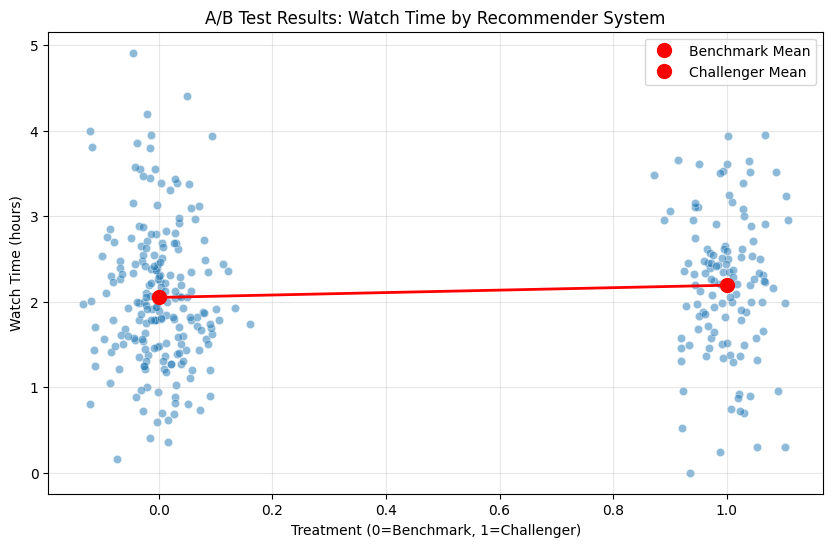

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create the visualization
plt.figure(figsize=(10, 6))

# Add some random jitter to x-axis to show distribution better
jitter = np.random.normal(0, 0.05, size=len(data))
x_jittered = (data['recommender'] == 'challenger').astype(int) + jitter

# Scatter plot with jitter
sns.scatterplot(x=x_jittered, y=data['watch_time'], alpha=0.5)

# Add regression line
x_range = np.array([0, 1])
y_predicted = result.params['Intercept'] + result.params['C(recommender)[T.challenger]'] * x_range
plt.plot(x_range, y_predicted, color='red', linewidth=2)

# Customize the plot
plt.xlabel('Treatment (0=Benchmark, 1=Challenger)')
plt.ylabel('Watch Time (hours)')
plt.title('A/B Test Results: Watch Time by Recommender System')

# Add mean points
plt.plot([0], [data[data['recommender']=='benchmark']['watch_time'].mean()], 
         'o', color='red', markersize=10, label='Benchmark Mean')
plt.plot([1], [data[data['recommender']=='challenger']['watch_time'].mean()], 
         'o', color='red', markersize=10, label='Challenger Mean')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

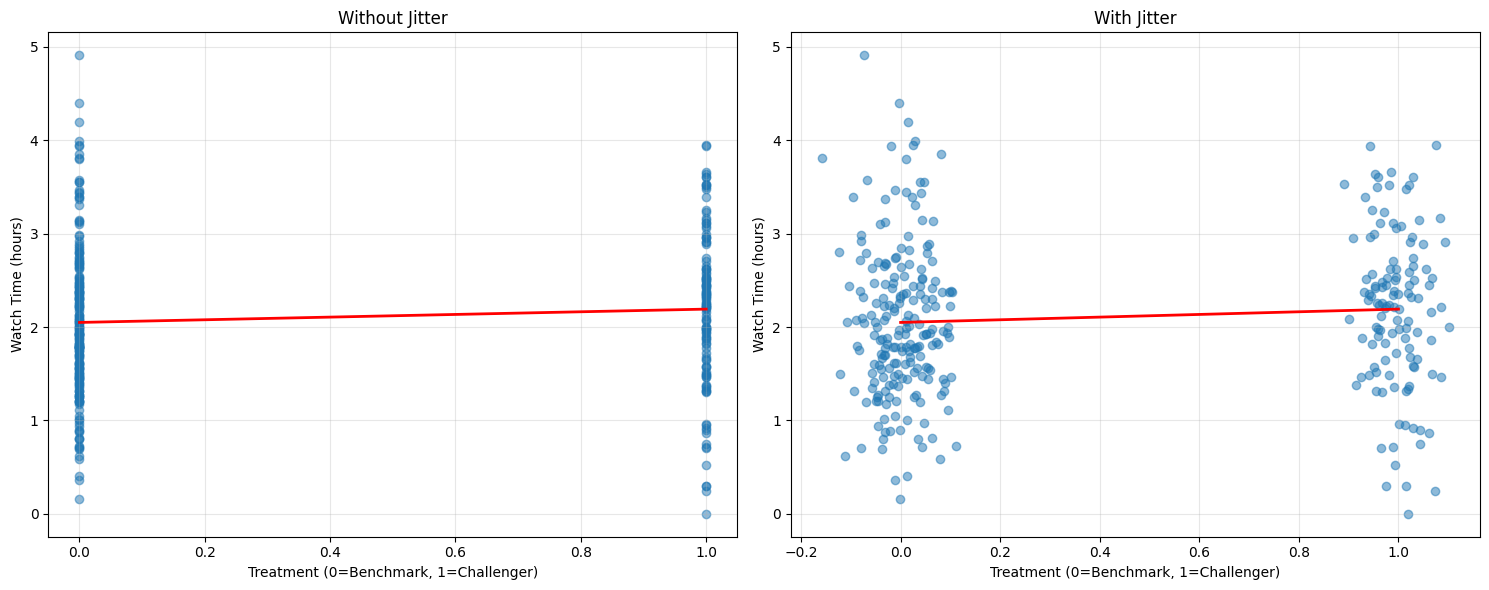

In [16]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot WITHOUT jitter
x_no_jitter = (data['recommender'] == 'challenger').astype(int)
ax1.scatter(x_no_jitter, data['watch_time'], alpha=0.5)
ax1.plot(x_range, y_predicted, color='red', linewidth=2)
ax1.set_title('Without Jitter')
ax1.set_xlabel('Treatment (0=Benchmark, 1=Challenger)')
ax1.set_ylabel('Watch Time (hours)')
ax1.grid(True, alpha=0.3)

# Plot WITH jitter
jitter = np.random.normal(0, 0.05, size=len(data))
x_jittered = x_no_jitter + jitter
ax2.scatter(x_jittered, data['watch_time'], alpha=0.5)
ax2.plot(x_range, y_predicted, color='red', linewidth=2)
ax2.set_title('With Jitter')
ax2.set_xlabel('Treatment (0=Benchmark, 1=Challenger)')
ax2.set_ylabel('Watch Time (hours)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()